In [1]:
import pystac

In [3]:
items = pystac.ItemCollection.from_file('rhodes_sentinel-2.json')

In [4]:
item = items[0]

In [5]:
red_href = item.assets["red"].get_absolute_href()
nir_href = item.assets["nir"].get_absolute_href()

In [6]:
red_href

'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/35/S/NA/2023/8/S2A_35SNA_20230827_0_L2A/B04.tif'

In [7]:
import rioxarray

In [8]:
red = rioxarray.open_rasterio(red_href, masked=True, overview_level=1)

In [9]:
nir = rioxarray.open_rasterio(nir_href, masked=True, overview_level=1)

In [10]:
import geopandas

In [11]:
rhodes = geopandas.read_file('rhodes.gpkg')

In [16]:
rhodes_reprojected = rhodes.to_crs(red.rio.crs)

In [17]:
bbox = rhodes_reprojected.total_bounds

In [18]:
bbox

array([ 561505.80329814, 3970451.33353859,  611872.89042946,
       4035463.69404871])

In [19]:
red_clip = red.rio.clip_box(*bbox)
nir_clip = nir.rio.clip_box(*bbox)

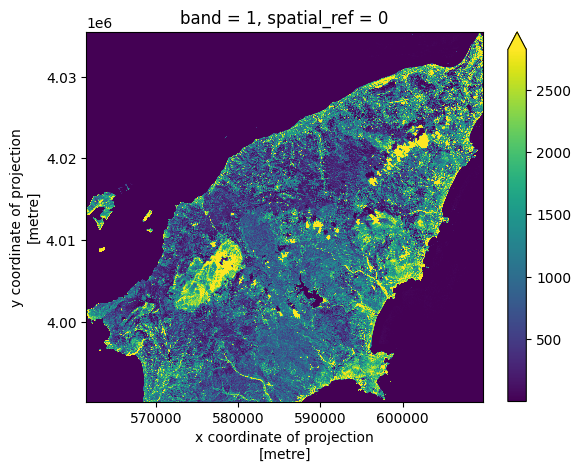

In [20]:
red_clip.plot(robust=True)

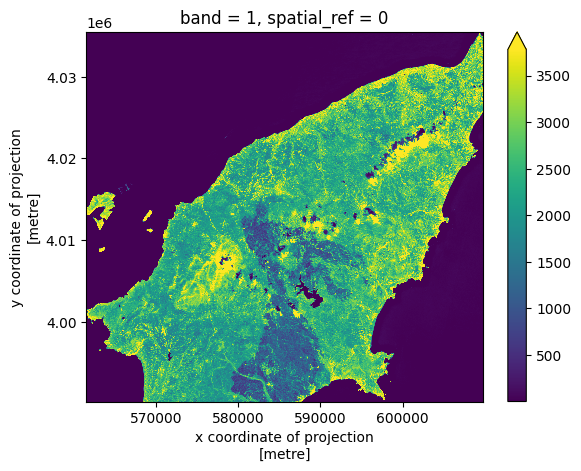

In [21]:
nir_clip.plot(robust=True)

## Raster Math

In [22]:
print(red_clip.shape, nir_clip.shape)

(1, 1131, 1207) (1, 1131, 1207)


NDVI = ( nir - red ) / ( nir + red )

In [23]:
ndvi = (nir_clip - red_clip) / (nir_clip + red_clip)

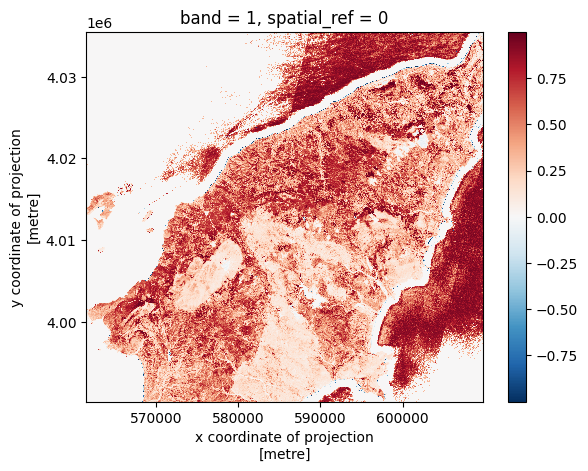

In [24]:
ndvi.plot()

(array([  1171.,    524.,    449.,    856., 435047., 167377., 240492.,
        193298., 172043., 153860.]),
 array([-9.97663558e-01, -7.97933936e-01, -5.98204315e-01, -3.98474663e-01,
        -1.98745042e-01,  9.84579325e-04,  2.00714201e-01,  4.00443822e-01,
         6.00173473e-01,  7.99903095e-01,  9.99632716e-01]),
 <BarContainer object of 10 artists>)

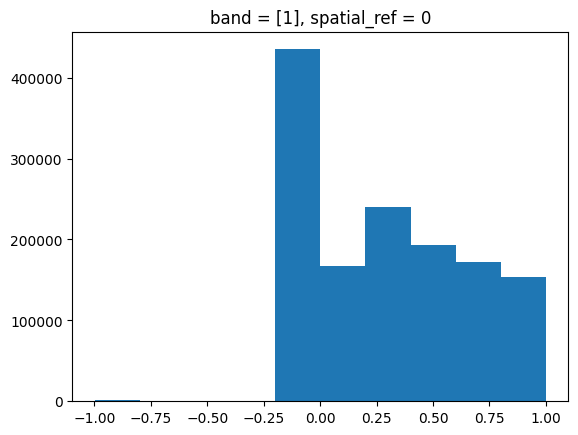

In [25]:
ndvi.plot.hist()

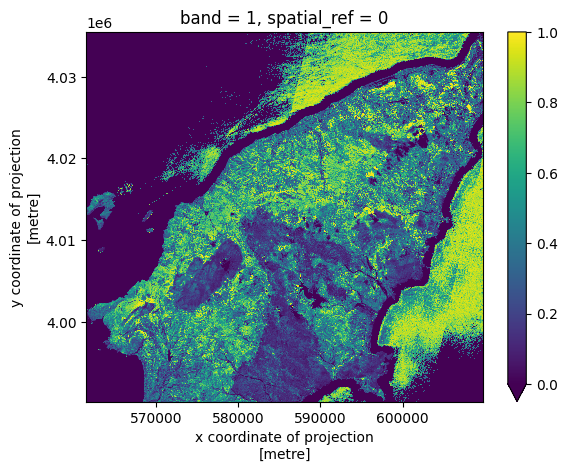

In [26]:
ndvi.plot(vmin=0, vmax=1)

Exercise: NDWI and custom index to detect burned areas

Calculate the other two indices required to compute the burned area classification mask, specifically:-     The normalized difference water index (NDWI), derived from the green and NIR bands (with band ID "green" and "nir", respective
    
$$ NDWI = ( green - NIR) / (green + NIR) $$ly- 
    A custom index derived from the 1600 nm and the 2200 nm short-wave infrared (SWIR) bands ( "swir16" and "swir22", respecti

$$ INDEX = (SWIR16 - SWIR22) / (SWIR16 + SWIR22) $$vely):

What challenge do you foresee in combining the information from all computed indices?

In [27]:
def get_band_and_clip(item, band_name, bbox, ov_level=1):
    href = item.assets[band_name].get_absolute_href()
    band = rioxarray.open_rasterio(href, masked=True, overview_level=ov_level)
    return band.rio.clip_box(*bbox)

In [28]:
green_clip = get_band_and_clip(item, 'green', bbox)
swir16_clip = get_band_and_clip(item, 'swir16', bbox)
swir22_clip = get_band_and_clip(item, 'swir22', bbox)

In [29]:
ndwi = (green_clip - nir_clip) / (green_clip + nir_clip)
index = (swir16_clip - swir22_clip) / (swir16_clip + swir22_clip)

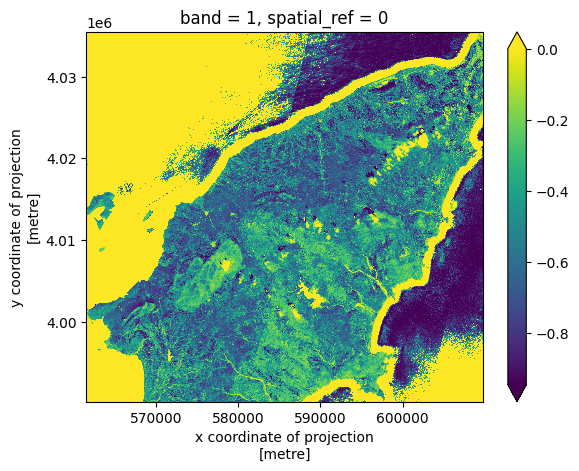

In [30]:
ndwi.plot(robust=True)

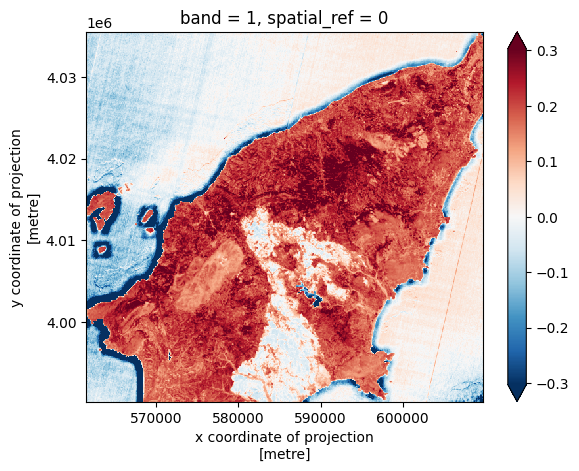

In [31]:
index.plot(robust=True)

In [32]:
ndvi.rio.resolution(), ndwi.rio.resolution(), index.rio.resolution()

((40.0, -40.0), (40.0, -40.0), (79.97086671522219, -79.97086671522233))

In [33]:
index_match = index.rio.reproject_match(ndvi)
swir16_clip_match = swir16_clip.rio.reproject_match(ndvi)

In [34]:
index_match.rio.resolution()

(40.0, -40.0)

burned = 
ndvi <= 0.3
ndwi <= 0.1
index_match + nir_clip <= 0.1
blue_clip <= 0.1
swir16_clip >= 0.1

In [35]:
blue_clip = get_band_and_clip(item, 'blue', bbox)

In [36]:
burned = (
    (ndvi <= 0.3) &
    (ndwi <= 0.1) &
    ((index_match + nir_clip/10000) <= 0.1) &
    ((blue_clip/10000) <= 0.1) &
    ((swir16_clip_match/10000) >= 0.1)
)

In [41]:
burned = burned.squeeze()

In [42]:
burned.shape

(1131, 1207)

In [44]:
visual_href = item.assets['visual'].get_absolute_href()
visual = rioxarray.open_rasterio(visual_href, overview_level=1)
visual_clip = visual.rio.clip_box(*bbox)

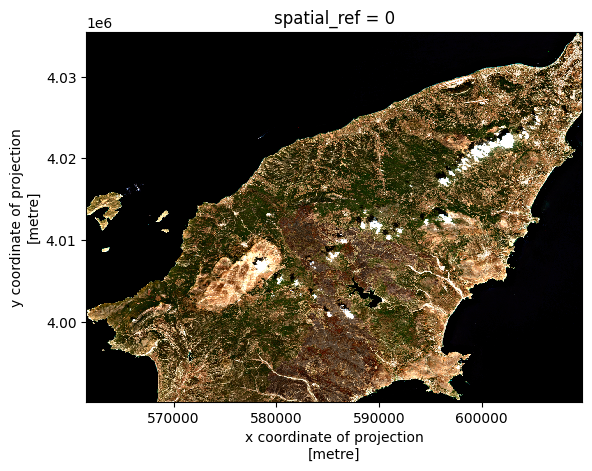

In [48]:
visual_clip.plot.imshow()

In [50]:
visual_clip[0] = visual_clip[0].where(~burned, 255)
visual_clip[1:3] = visual_clip[1:3].where(~burned, 0)

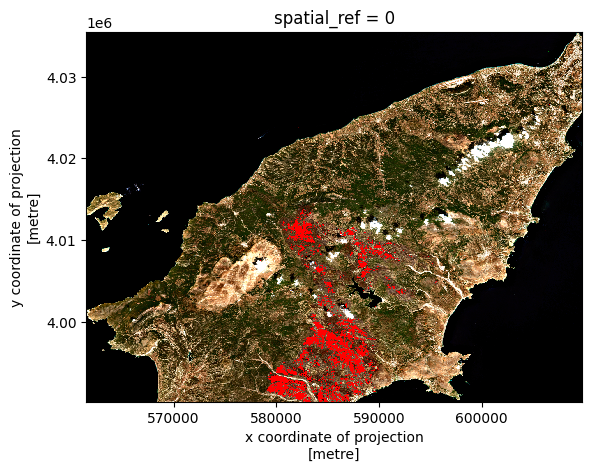

In [51]:
visual_clip.plot.imshow()

In [52]:
burned.rio.to_raster('burned.tif', dtype='int8')